<a href="https://colab.research.google.com/github/RamSaw/deep-unsupervised-learning/blob/master/HW01_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2.1 MADE

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import tqdm
from mpl_toolkits.mplot3d import Axes3D
SEED = 24839
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

(200, 200)


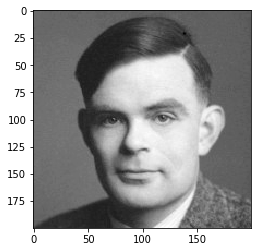

In [4]:
distribution = np.load('./distribution.npy')
print(distribution.shape)
plt.imshow(distribution, cmap='gray')

In [0]:
def plot_3D_dist(dist):
  fig = plt.figure(figsize=(13, 7))
  ax = plt.axes(projection='3d')
  X1 = np.arange(200)
  X2 = np.arange(200)
  X1, X2 = np.meshgrid(X1, X2)
  surf = ax.plot_surface(X1, X2, dist, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
  ax.set_xlabel('x1')
  ax.set_ylabel('x2')
  ax.set_zlabel('PDF')
  ax.set_title('Probability distribution')
  fig.colorbar(surf, shrink=0.5, aspect=5)
  ax.view_init(60, 35)
  plt.show()

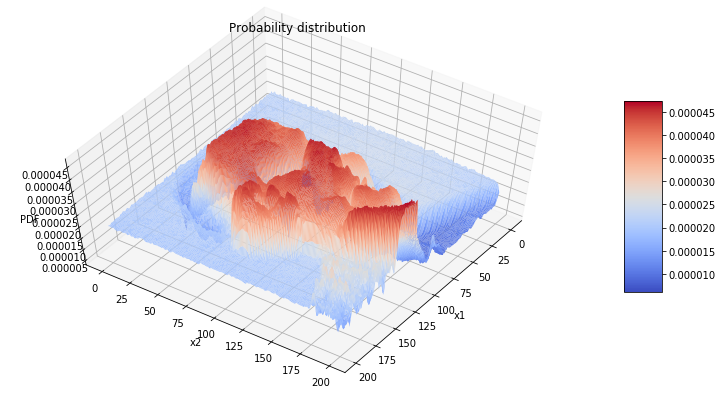

In [6]:
plot_3D_dist(distribution)

In [0]:
def sample_dataset(n):
  flattened = distribution.flatten()
  sampled = np.random.choice(200 * 200, n, p=flattened)
  X1 = (sampled / 200).astype('int').reshape((-1, 1))
  X2 = (sampled % 200).astype('int').reshape((-1, 1))
  return np.hstack((X1, X2))

def X_to_empirical_probs_2D(X):
  probs = np.zeros((200, 200))
  unique, counts = np.unique(X, return_counts=True, axis=0)
  probs[unique[:, 0], unique[:, 1]] += counts
  probs /= len(X)
  return probs

(100000, 2)


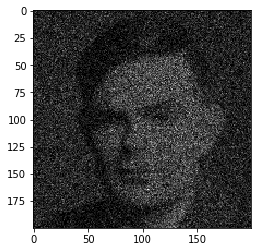

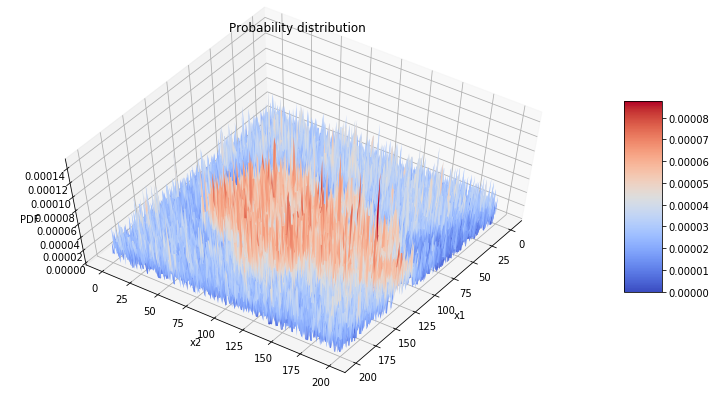

In [8]:
dataset = sample_dataset(100000)
print(dataset.shape)
plt.imshow(X_to_empirical_probs_2D(dataset), cmap='gray')
plot_3D_dist(X_to_empirical_probs_2D(dataset))

In [9]:
X_train_mlp, X_test_mlp = train_test_split(dataset, test_size=0.2, random_state=42)
#X_val_mlp = sample_dataset(int(len(dataset) * 0.01))
X_train_mlp, X_val_mlp = train_test_split(X_train_mlp, test_size=0.125, random_state=22)
X_train_mlp, X_val_mlp, X_test_mlp = torch.tensor(X_train_mlp), torch.tensor(X_val_mlp), torch.tensor(X_test_mlp)
print(X_train_mlp.shape)
print(X_train_mlp[:3])
print(X_val_mlp.shape)
print(X_val_mlp[:3])
print(X_test_mlp.shape)
print(X_test_mlp[:3])

torch.Size([70000, 2])
tensor([[ 49,  96],
        [113, 154],
        [ 83, 127]])
torch.Size([10000, 2])
tensor([[ 87, 147],
        [168,   0],
        [119, 177]])
torch.Size([20000, 2])
tensor([[ 78, 141],
        [ 66, 117],
        [ 35, 199]])


In [10]:
def loss_function(probs):
  return -torch.sum(torch.log(probs))

loss_function(torch.tensor([0.2, 0.2, 0.6]))

tensor(3.7297)

In [11]:
def get_mask_functions(layers_sizes, dimensions):
  m0 = torch.arange(1, dimensions + 1)
  m = [m0[torch.randperm(m0.size()[0])]]
  for l in range(1, layers_sizes.shape[0] + 1):
    min_prev = torch.min(m[l - 1])
    m_l = np.random.choice(np.arange(min_prev, dimensions), layers_sizes[l - 1])
    m.append(torch.tensor(m_l))
  return m

print(get_mask_functions(np.array([4, 2]), 5))

[tensor([4, 3, 2, 5, 1]), tensor([4, 3, 4, 4]), tensor([3, 4])]


In [34]:
def get_mask_by_functions(m1, m2):
  m1 = m1.reshape(-1, 1).expand(-1, m2.shape[0])
  m2 = m2.expand(m1.shape[0], -1)
  return (m1 >= m2).float()

get_mask_by_functions(torch.tensor([4, 1, 4, 2]), torch.tensor([2, 3]))

tensor([[1., 1.],
        [0., 0.],
        [1., 1.],
        [1., 0.]])

In [35]:
def get_masks(layers_sizes, dimensions):
  m = get_mask_functions(layers_sizes, dimensions)
  masks = []
  L = layers_sizes.shape[0]
  for l in range(1, L + 1):
    masks.append(get_mask_by_functions(m[l], m[l - 1]))
  masks.append(get_mask_by_functions(m[0], m[L]))
  return masks

print(get_masks(np.array([4, 2]), 5))

[tensor([[1., 0., 0., 0., 1.],
        [1., 1., 1., 0., 1.],
        [1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 1.]]), tensor([[1., 1., 1., 1.],
        [0., 0., 0., 1.]]), tensor([[0., 1.],
        [1., 1.],
        [0., 1.],
        [1., 1.],
        [0., 1.]])]


In [71]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        
    def forward(self, x, mask):
        return F.linear(x, mask * self.weight, self.bias)

def test_masked_linear():
  model = MaskedLinear(2, 3)
  for param in model.parameters():
      if param.requires_grad:
          print(param.data.shape)
  print(model(torch.tensor([130, 1/70]), torch.tensor([[1, 0], [0, 1], [1, 0]])))

test_masked_linear()

torch.Size([3, 2])
torch.Size([3])
tensor([ 88.1686,  -0.5281, -10.0376], grad_fn=<AddBackward0>)


In [140]:
class MADE(nn.Module):
  def __init__(self, dimensions=2, n_classes=200, hidden_size=200):
    self.n_classes = n_classes
    self.dimensions = dimensions
    super(MADE, self).__init__()
    self.masked1 = MaskedLinear(dimensions * n_classes, hidden_size)
    self.relu = nn.ReLU()
    self.masked2 = MaskedLinear(hidden_size, dimensions * n_classes)
    self.softmax = nn.Softmax(dim=2)
  
  def forward(self, x, masks):
    x1, x2 = x[:, 0], x[:, 1]
    one_hot_x1, one_hot_x2 = torch.zeros((x1.shape[0], self.n_classes)), torch.zeros((x2.shape[0], self.n_classes))
    one_hot_x1[torch.arange(x1.shape[0]), x1] = 1
    one_hot_x2[torch.arange(x2.shape[0]), x2] = 1
    input_x = torch.cat((one_hot_x1, one_hot_x2), 1)
    out = self.masked1(input_x, masks[0])
    out = self.relu(out)
    out = self.masked2(out, masks[1])
    out = out.view(-1, self.dimensions, self.n_classes)
    out = self.softmax(out)
    probs_x1 = out[torch.arange(x1.shape[0]), 0, x1]
    probs_x2 = out[torch.arange(x2.shape[0]), 1, x2]
    #assert(torch.all((input_x.view(-1, self.dimensions, self.n_classes) * out).sum(dim=2)[:, 0] == probs_x1))
    #assert(torch.all((input_x.view(-1, self.dimensions, self.n_classes) * out).sum(dim=2)[:, 1] == probs_x2))
    return probs_x1 * probs_x2

def test_MADE():
  model = MADE(2, 3, 4)
  for param in model.parameters():
      if param.requires_grad:
        print(param.data.shape)
  mask = torch.tensor([[1, 0, 0, 1], [0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], [0, 1, 0, 0], [0, 0, 1, 0]])
  masks = [mask.T, mask]
  print(model(torch.tensor([[0, 2], [1, 1], [0, 0]]), masks))
test_MADE()

torch.Size([4, 6])
torch.Size([4])
torch.Size([6, 4])
torch.Size([6])
tensor([0.0990, 0.0723, 0.1540], grad_fn=<MulBackward0>)


In [0]:
def loss_function(probs):
  return -torch.sum(torch.log(probs)) / len(probs)

In [142]:
def train(model_class, X_train, X_val, lr, batch_size, epochs, num_labels):
  trainloader = DataLoader(X_train, batch_size=batch_size)
  hidden_size = 200
  layers_sizes = np.array([hidden_size])
  dimensions = 2 * num_labels
  model = model_class()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  
  num_batches = len(trainloader)
  losses_train = []
  losses_val = []
  
  for epoch in range(epochs):
    for i, batch in enumerate(trainloader):
      optimizer.zero_grad()
      masks = get_masks(layers_sizes, dimensions)
      output = model(batch, masks)
      loss_train = loss_function(output)
      loss_train.backward()
      losses_train.append(np.log2(float(loss_train)) / 2)
      optimizer.step()
      
      with torch.no_grad():
        output = model(X_val, masks)
        loss_val = loss_function(output)
        losses_val.append(np.log2(float(loss_val)) / 2)
    with torch.no_grad():
        output = model(X_val, get_masks(layers_sizes, dimensions))
        loss_val = loss_function(output)
        print(f'Loss on validation: {np.log2(float(loss_val)) / 2}')
  return model, losses_train, losses_val

model, losses_train, losses_val = train(MADE, X_train_mlp, X_val_mlp, 0.01, 200, 20, 200)

Loss on validation: 1.701902930993139
Loss on validation: 1.7011928083593277
Loss on validation: 1.7007099550426665
Loss on validation: 1.7003644896175814
Loss on validation: 1.7001272892916053
Loss on validation: 1.699950429507187
Loss on validation: 1.6999070876834517
Loss on validation: 1.699828479175223
Loss on validation: 1.6998441885255267
Loss on validation: 1.6998130954135013
Loss on validation: 1.6997564464455834
Loss on validation: 1.6997484278778168
Loss on validation: 1.6997540995569267
Loss on validation: 1.6997685719153386
Loss on validation: 1.6996884487717112
Loss on validation: 1.69972469761034
Loss on validation: 1.6997397572936703
Loss on validation: 1.6997079425282327
Loss on validation: 1.6997374755436783
Loss on validation: 1.699710419957887


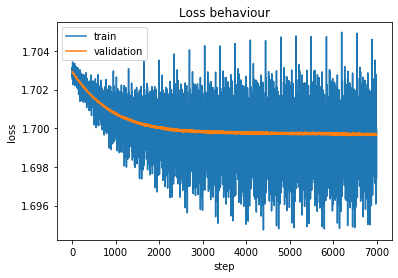

In [143]:
fig, ax = plt.subplots()
ax.set(xlabel='step', ylabel='loss',
       title='Loss behaviour')
ax.plot(np.arange(len(losses_train)), losses_train, label="train")
ax.plot(np.arange(0, len(losses_train)), losses_val, label="validation")
ax.legend()
plt.show()

In [144]:
with torch.no_grad():
  hidden_size = 200
  layers_sizes = np.array([hidden_size])
  dimensions = 2 * 200
  output = model(X_test_mlp, get_masks(layers_sizes, dimensions))
  loss_test = loss_function(output)
  print(f'Loss on test: {np.log2(float(loss_test)) / 2}')

Loss on test: 1.6996051868982538


In [0]:
def sample_from_model(n, model_p):
  sampled = np.random.choice(200 * 200, n, p=model_p)
  dataset = np.zeros((n, 2))
  X1 = (sampled / 200).astype('int').reshape((-1, 1))
  X2 = (sampled % 200).astype('int').reshape((-1, 1))
  return np.hstack((X1, X2))

1.0019091


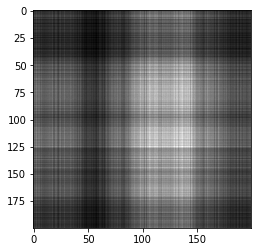

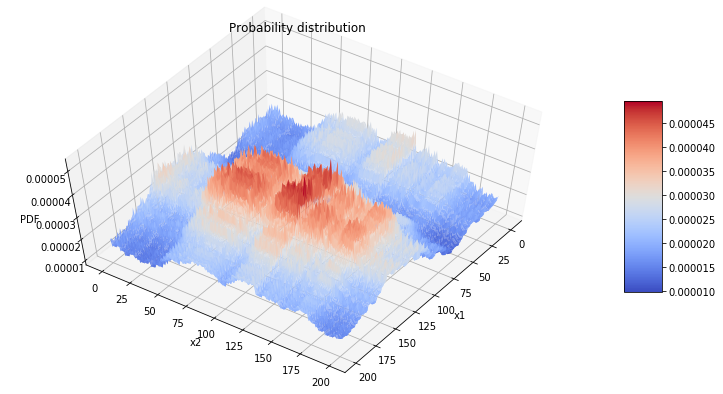

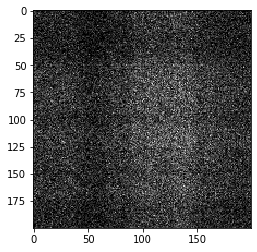

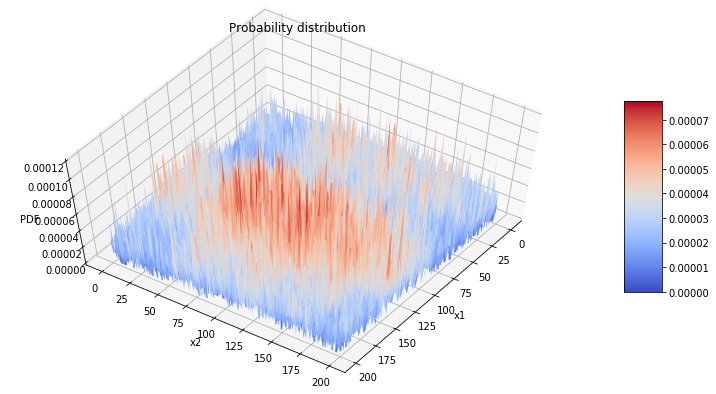

In [146]:
x = np.array([[(i, j) for j in np.arange(200)] for i in np.arange(200)], dtype=np.int64)
x = x.reshape(-1, 2)
model_p = model(x, get_masks(np.array([200]), 2 * 200))
model_p = model_p.detach().numpy()
print(np.sum(model_p))
model_p /= np.sum(model_p)
plt.imshow(model_p.reshape((200, 200)), cmap='gray')
plot_3D_dist(model_p.reshape((200, 200)))
sampled_from_model = sample_from_model(100000, model_p)
plt.imshow(X_to_empirical_probs_2D(sampled_from_model), cmap='gray')
plot_3D_dist(X_to_empirical_probs_2D(sampled_from_model))